
### 1. Import Dependencies

In [121]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import PIL
from PIL import Image

import pathlib
from pathlib import Path
#Import tensorflow dependencies
from tensorflow.keras.models import Model

#### Versions

In [124]:
!python --version
print("Tensorflow-", tf.__version__)
print("Numpy-", np.__version__)
print("Matplotlib-", matplotlib.__version__)
print("PIL-", PIL.__version__)

Python 3.10.1
Tensorflow- 2.14.0
Numpy- 1.24.4
Matplotlib- 3.5.1
PIL- 9.0.0


### 2.Setup Paths

In [90]:
MAIN_PATH = Path.cwd()
print(MAIN_PATH)

E:\Class\Placement Dusted\companies\Dashtoon


In [91]:
CONTENT_PATH = MAIN_PATH.joinpath("data/content_image")
STYLE_PATH = MAIN_PATH.joinpath("data/style_image")
MODEL_PATH = MAIN_PATH.joinpath("pretrained_model/imagenet-vgg-verydeep-19.mat")

print(CONTENT_PATH)
print(STYLE_PATH)
print(MODEL_PATH)

E:\Class\Placement Dusted\companies\Dashtoon\data\content_image
E:\Class\Placement Dusted\companies\Dashtoon\data\style_image
E:\Class\Placement Dusted\companies\Dashtoon\pretrained_model\imagenet-vgg-verydeep-19.mat


### 3.Read in Content and Style Images

In [92]:
content_image_path = CONTENT_PATH.joinpath("paris.jpg")
style_image_path = STYLE_PATH.joinpath("starry_night.jpg")

print(content_image_path)
print(style_image_path)

E:\Class\Placement Dusted\companies\Dashtoon\data\content_image\paris.jpg
E:\Class\Placement Dusted\companies\Dashtoon\data\style_image\starry_night.jpg


#### Lets open and see the content image and style images

(1, 400, 400, 3)


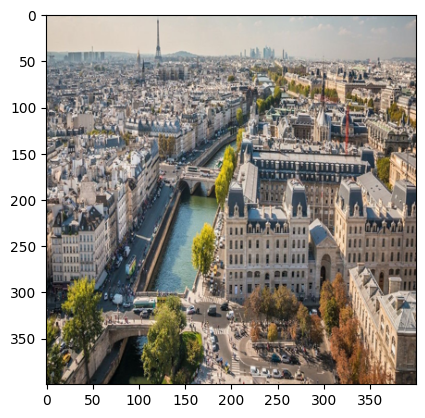

In [93]:
content_image = np.array(Image.open(content_image_path.as_posix()).resize((400, 400)))
# content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
content_image = tf.expand_dims(content_image , axis = 0)

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


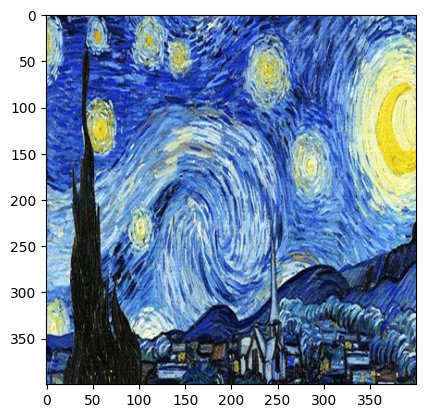

In [94]:
style_image =  np.array(Image.open(style_image_path).resize((400, 400)))
# style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
style_image = tf.expand_dims(style_image , axis = 0)
print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

#### Lets add some noise to the content image

(1, 400, 400, 3)


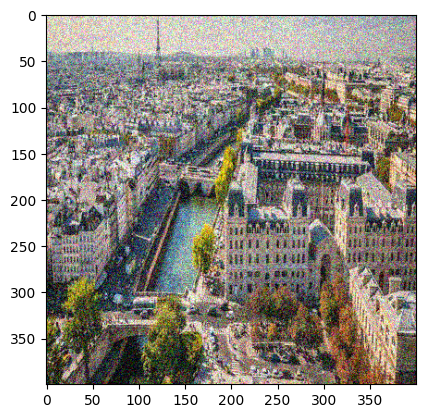

In [95]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(generated_image)
print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

(1, 400, 400, 3)


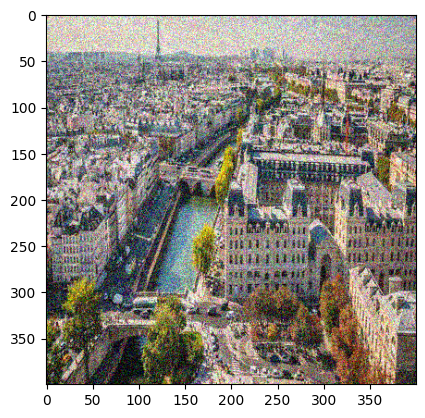

In [96]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(generated_image)
print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

### 4. Load the Model

In [97]:
model = tf.keras.applications.VGG19(include_top = False,
                                    weights = 'imagenet',
                                    input_shape = (400, 400, 3))

model.trainable = False

### 6.Model

#### 6.1 Get model layers names

In [98]:
layers = model.layers
for layer in layers:
  print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [99]:
content_layer = [('block5_conv4', 1)]

In [100]:
style_layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

#### 6.2 Get image encodings

In [101]:
def get_layer_outputs(model, layer_names):
  outputs = []
  for layer_name, weight in layer_names:
    outputs.append(model.get_layer(layer_name).output)
  
  return Model(inputs = [model.input], outputs = outputs)

content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(model, style_layers + content_layer)
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image) 

In [102]:
preprocessed_content =  tf.image.convert_image_dtype(content_image, tf.float32)
content_encodings = vgg_model_outputs(preprocessed_content)

In [103]:
preprocessed_style =  tf.image.convert_image_dtype(style_image, tf.float32)
style_encodings = vgg_model_outputs(preprocessed_style)

### 7.Define content, style and total losses

In [104]:
def content_loss(content_encodings, generated_encodings):
    """
    content loss is the FROBENIUS NORM of the tensors.
    """
    a_C = content_encodings[-1]
    a_G = generated_encodings[-1]
    
    _, n_H, n_W, n_C = a_C.get_shape().as_list()
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))
    
    return J_content / (4 * n_H * n_W * n_C)

def layer_style_loss(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.squeeze(tf.transpose(tf.reshape(a_S, shape = [1, -1, n_C]), perm = [0, 2, 1]), axis = 0)
    a_G = tf.squeeze(tf.transpose(tf.reshape(a_G, shape = [1, -1, n_C]), perm = [0, 2, 1]), axis = 0)
    
    # Computing gram_matrices for both images S and G
    GS = tf.matmul(a_S, tf.transpose(a_S, perm = [1,0]))
    GG = tf.matmul(a_G, tf.transpose(a_G, perm = [1,0]))
    
    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS , GG))) / (2 * n_H * n_W * n_C) ** 2
    
    return J_style_layer

def style_loss(style_encodings, generated_encodings, style_layers = style_layers):
    J_style = 0
    
    a_S = style_encodings[:-1]
    
    a_G = generated_encodings[:-1]
    
    for i, (layer_name, weight) in zip(range(len(a_S)), style_layers):  
        # Compute style_cost for the current layer
        layer_cost = layer_style_loss(a_S[i], a_G[i])
        
        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight * layer_cost
    
    return J_style

def total_loss(J_content, J_style, alpha = 10, beta = 40):
    return alpha * J_content + beta * J_style


### 8.Define train_step and train functions

In [105]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
  
def tensor_to_image(tensor):
  """
  Converts the given tensor into a PIL image
  
  Arguments:
  tensor -- Tensor
  
  Returns:
  Image: A PIL image
  """
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
  return Image.fromarray(tensor)

In [106]:
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(pp_generated):
  with tf.GradientTape() as tape:
    generated_encodings = vgg_model_outputs(generated_image)

    J_content = content_loss(content_encodings, generated_encodings)

    J_style = style_loss(style_encodings, generated_encodings, style_layers)

    J = total_loss(J_content, J_style, 10, 500000)

  grad = tape.gradient(J, generated_image)

  optimizer.apply_gradients([(grad, generated_image)])
  generated_image.assign(clip_0_1(generated_image))
  
  return J

In [107]:
EPOCHS = 2
def train(pp_generated, EPOCHS = EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print(f'\n Epoch {epoch}/{EPOCHS}')
    train_step(generated_image)


In [108]:
train(generated_image, 300)


 Epoch 1/300

 Epoch 2/300

 Epoch 3/300

 Epoch 4/300

 Epoch 5/300

 Epoch 6/300

 Epoch 7/300

 Epoch 8/300

 Epoch 9/300

 Epoch 10/300

 Epoch 11/300

 Epoch 12/300

 Epoch 13/300

 Epoch 14/300

 Epoch 15/300

 Epoch 16/300

 Epoch 17/300

 Epoch 18/300

 Epoch 19/300

 Epoch 20/300

 Epoch 21/300

 Epoch 22/300

 Epoch 23/300

 Epoch 24/300

 Epoch 25/300

 Epoch 26/300

 Epoch 27/300

 Epoch 28/300

 Epoch 29/300

 Epoch 30/300

 Epoch 31/300

 Epoch 32/300

 Epoch 33/300

 Epoch 34/300

 Epoch 35/300

 Epoch 36/300

 Epoch 37/300

 Epoch 38/300

 Epoch 39/300

 Epoch 40/300

 Epoch 41/300

 Epoch 42/300

 Epoch 43/300

 Epoch 44/300

 Epoch 45/300

 Epoch 46/300

 Epoch 47/300

 Epoch 48/300

 Epoch 49/300

 Epoch 50/300

 Epoch 51/300

 Epoch 52/300

 Epoch 53/300

 Epoch 54/300

 Epoch 55/300

 Epoch 56/300

 Epoch 57/300

 Epoch 58/300

 Epoch 59/300

 Epoch 60/300

 Epoch 61/300

 Epoch 62/300

 Epoch 63/300

 Epoch 64/300

 Epoch 65/300

 Epoch 66/300

 Epoch 67/300

 Ep

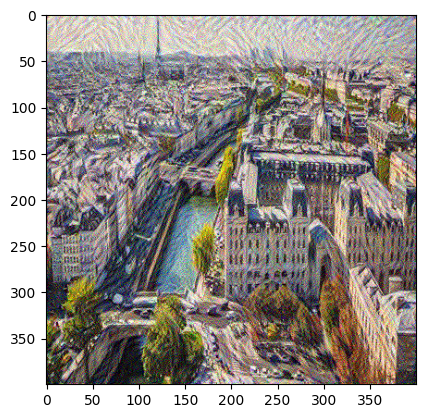

In [110]:
plt.imshow(tensor_to_image(generated_image))